# 1. Visualizing Filter Maximizations

In [1]:
import tensorflow as tf
from tensorflow.math import sqrt, square, reduce_mean
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import cv2

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) >= 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.1 What type of image maximizes each convolutional filter?

## 1.1a Load a pretrained VGG16 model without the top

In [2]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
vgg_model.trainable = False

vgg_model.summary()
for layer in vgg_model.layers:
    if 'conv' not in layer.name:
        continue

    filters, biases = layer.get_weights()
    print(layer.name, layer.output.shape)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 1.1b Extract layer `block3_conv1`

In [3]:
model_layer = vgg_model.get_layer('block3_conv1')
output_layer = model_layer.output
(_, filter_width, filter_height, output_layer_filters) = output_layer.shape
activation_modal = Model(vgg_model.input, output_layer)

## 1.2 Build a loss function that seeks to maximize the activation of the model layer

In [4]:

def maximization_loss(output, filter_idx):
    return -reduce_mean(output[:,:,:, filter_idx])

## 1.3 Use a loop to perform stochastic gradient decent for 500 steps

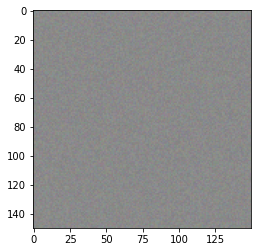

In [5]:
image_width = 150
image_height = 150
image = np.random.random((1, image_width, image_height, 3)) * 20 + 128.
image = image / 255.

plt.imshow(image[0])

In [6]:
epochs = 500
image = tf.Variable(image)

for epoch in range(epochs):
    if epoch % 100 == 0: print("epoch: {}".format(epoch))
    # 1.3a Use GradientTape to keep track of the forward passes while calculating each loss
    with tf.GradientTape() as tape:
        tape.watch(image)
        output = activation_modal(image.value())
        loss = maximization_loss(output, 15)

    # 1.3b Apply the normalized gradient to the original image
    grads = tape.gradient(loss, image)
    grads /= (sqrt(reduce_mean(square(grads))) + 1e-5)
    image.assign_add(grads * epoch)


epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400


In [7]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

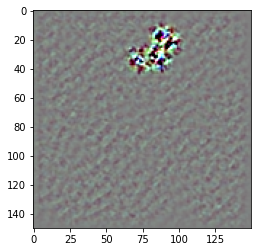

In [8]:
plt.imshow(deprocess_image(image.numpy()[0]))

## 1.4 Build a simple function and plot a few different filters from the layer

In [9]:
def new_random_img():
    image_width = 150
    image_height = 150
    image = np.random.random((1, image_width, image_height, 3)) * 20 + 128.
    image = image / 255.
    return image

In [10]:
def activate_image(img, filter):
    epochs = 500
    img = tf.Variable(img)
    for epoch in range(epochs):
        # 1.3a Use GradientTape to keep track of the forward passes while calculating each loss
        with tf.GradientTape() as tape:
            tape.watch(img)
            output = activation_modal(img.value())
            loss = maximization_loss(output, filter)

        # 1.3b Apply the normalized gradient to the original image
        grads = tape.gradient(loss, img)
        grads /= (sqrt(reduce_mean(square(grads))) + 1e-5)
        img.assign_add(grads * epoch)
    return img

In [11]:
images_to_show = 16
filters = [random.randint(0, output_layer_filters-1) for _ in range(images_to_show)]
processed_images = []

for _, filter in enumerate(filters):
    print(filter)
    img = new_random_img()
    img = activate_image(img, filter)
    processed_images.append(img)

27
65
27
217
135
51
71
182
224
47
65
13
49
246
56
174


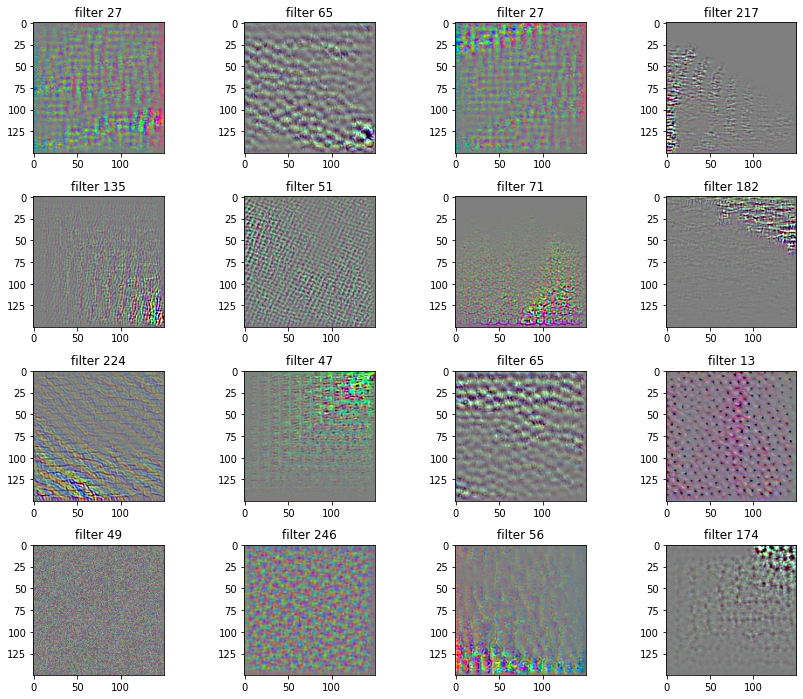

In [12]:
columns = 4
rows = (images_to_show // columns) + 1

fig = plt.figure(figsize=(12, 12))

for img_idx in range(len(processed_images)):
    img = deprocess_image(processed_images[img_idx][0].numpy())
    title = "filter {}".format(filters[img_idx])    

    img_plot = fig.add_subplot(rows, columns, img_idx+1)

    img_plot.set_title(title)
    img_plot.imshow(img)

plt.tight_layout()
plt.show(fig)

# 2. Grad-CAM Visualizations

## 2.1a Load Xception model pretrained on imagenet

In [13]:
# https://keras.io/examples/vision/grad_cam/
xception_model = Xception()

## 2.1b Store the names if the last convolution layers and the classifier layer names

In [14]:
xcption_conv_last = "block14_sepconv2_act"
xcption_class_last = ["avg_pool", "predictions"]

## 2.2  Build a function that generates the Grad-CAM heatmap

## 2.2a Create a model that maps the input image to the activations of the last conv layer

In [15]:
def gen_conv_model(model):
    xcption_conv_last = "block14_sepconv2_act"
    conv_last_layer = model.get_layer(xcption_conv_last)
    last_conv_model = Model(model.inputs, conv_last_layer.output)
    return last_conv_model


## 2.2b Create a model that maps the activations of the last conv layer to the final class predictions 

In [16]:
def gen_class_model(model):
    xcption_conv_last = "block14_sepconv2_act"
    xcption_class_last = ["avg_pool", "predictions"]

    conv_last_layer = model.get_layer(xcption_conv_last).output
    class_input_shape = conv_last_layer.shape[1:]

    class_input = Input(shape=class_input_shape)
    x = class_input
    for layer_name in xcption_class_last:
        x = model.get_layer(layer_name)(x)
    
    last_class_model = Model(class_input, x)
    return last_class_model

## 2.2c Compute the gradient using GradientTape of the top predicted class for the input image with respect to the activations of the last conv layer

In [17]:
def get_input_image(img_path):
    img_size = (299, 299)
    test_img = load_img(img_path, target_size=img_size)
    test_img = img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    return test_img

In [18]:
def process_gradients(conv_model, class_model, img):
    with tf.GradientTape() as tape:
        conv_output = conv_model(img)
        tape.watch(conv_output)

        preds = class_model(conv_output)
        preds_top = tf.argmax(preds[0])
        logit = preds[:, preds_top]

    grads = tape.gradient(logit, conv_output)
    return grads

## 2.2d Using the Xception Grads, create a vector where each entry in the mean intensity of the gradient over the feature map

In [19]:
def pool_gradients(grads):
    grads_pooled = reduce_mean(grads, axis=(0, 1, 2))
    return grads_pooled

## 2.2e Multiply each channel in the feature map array by how important it is with respect to the top predicted class

In [20]:
def multiply_top_predictions_by_grads(conv_model, img, grads_pooled):
    conv_output = conv_model(img)
    [conv_output_numpy] = conv_output.numpy()
    grads_pooled_numpy = grads_pooled.numpy()

    for filter_idx in range(grads_pooled_numpy.shape[0]):
        conv_output_numpy[:, :, filter_idx] *= grads_pooled_numpy[filter_idx]
    
    return conv_output_numpy

## 2.2f Use the channel-wise mean of the resulting figure map as the heatmap of the class activation

In [21]:
def normalize_heatmap(conv_output):
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

## 2.3 Use the Xception modal to predict the class of the test image and display the heatmap

In [22]:
test_img = get_input_image('bird.jpg')
test_img = preprocess_input(test_img)
preds = xception_model(test_img)
print("Predicted: {}".format(decode_predictions(preds.numpy(), top=1)[0]))

Predicted: [('n01558993', 'robin', 0.8403541)]


In [23]:
xcpt_conv_model = gen_conv_model(xception_model)
xcpt_class_model = gen_class_model(xception_model)

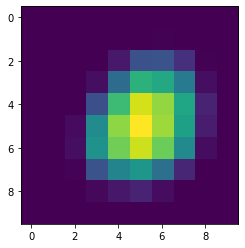

In [24]:
xcpt_grads = process_gradients(xcpt_conv_model, xcpt_class_model, test_img)
xcpt_grads = pool_gradients(xcpt_grads)
xcpt_heatmap = multiply_top_predictions_by_grads(xcpt_conv_model, test_img, xcpt_grads)
xcpt_heatmap = normalize_heatmap(xcpt_heatmap)

plt.imshow(xcpt_heatmap)

## 2.4 Overlay this heatmap onto the test image

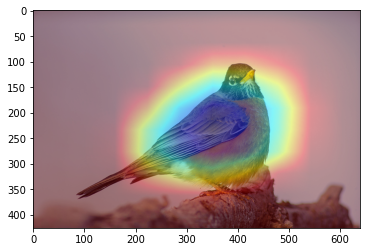

In [25]:
test_img_full = mpimg.imread('bird.jpg')

xcpt_heatmap_full = cv2.resize(xcpt_heatmap, (test_img_full.shape[1], test_img_full.shape[0]))
xcpt_heatmap_full = np.uint8(xcpt_heatmap_full * 255)
xcpt_heatmap_full = np.reshape(xcpt_heatmap_full, (xcpt_heatmap_full.shape[0], xcpt_heatmap_full.shape[1], 1))
xcpt_heatmap_full = cv2.applyColorMap(xcpt_heatmap_full, cv2.COLORMAP_JET)

plt.imshow(test_img_full)
plt.imshow(xcpt_heatmap_full, alpha=0.4)